# Benchmark: Schoof in-house dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import protvi.benchmark_models as bm
import protvi.plots as pl
import scanpy as sc
import scvi
import seaborn as sns
import torch
from protvi.model import PROTVI

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(0)
scvi.settings.seed = 0

Seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../data/processed/"
DATA_PATH = os.path.join(DATA_DIR, "schoof_protein_pca.h5ad")

In [3]:
def renamer(name: str) -> str:
    return name.lower().replace(" ", "_")

In [4]:
adata = sc.read(DATA_PATH)

adata.obs.columns = [renamer(col) for col in adata.obs.columns]
adata.var.columns = [renamer(col) for col in adata.var.columns]

uns = adata.uns.copy()
adata.uns = {}
for key, val in uns.items():
    adata.uns[renamer(key)] = val

adata.layers["log2_raw"] = adata.layers["log2_raw_sn"]
del adata.layers["log2_raw_sn"]

In [5]:
adata.X = adata.layers["log2_raw"].copy()
adata.X[np.isnan(adata.layers["median_ratios"])] = np.nan
adata.layers["log2_raw"] = adata.X.copy()

In [6]:
adata.X = bm.impute_knn(adata, layer="log2_raw")

In [9]:
sc.tl.pca(adata, n_comps=16)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

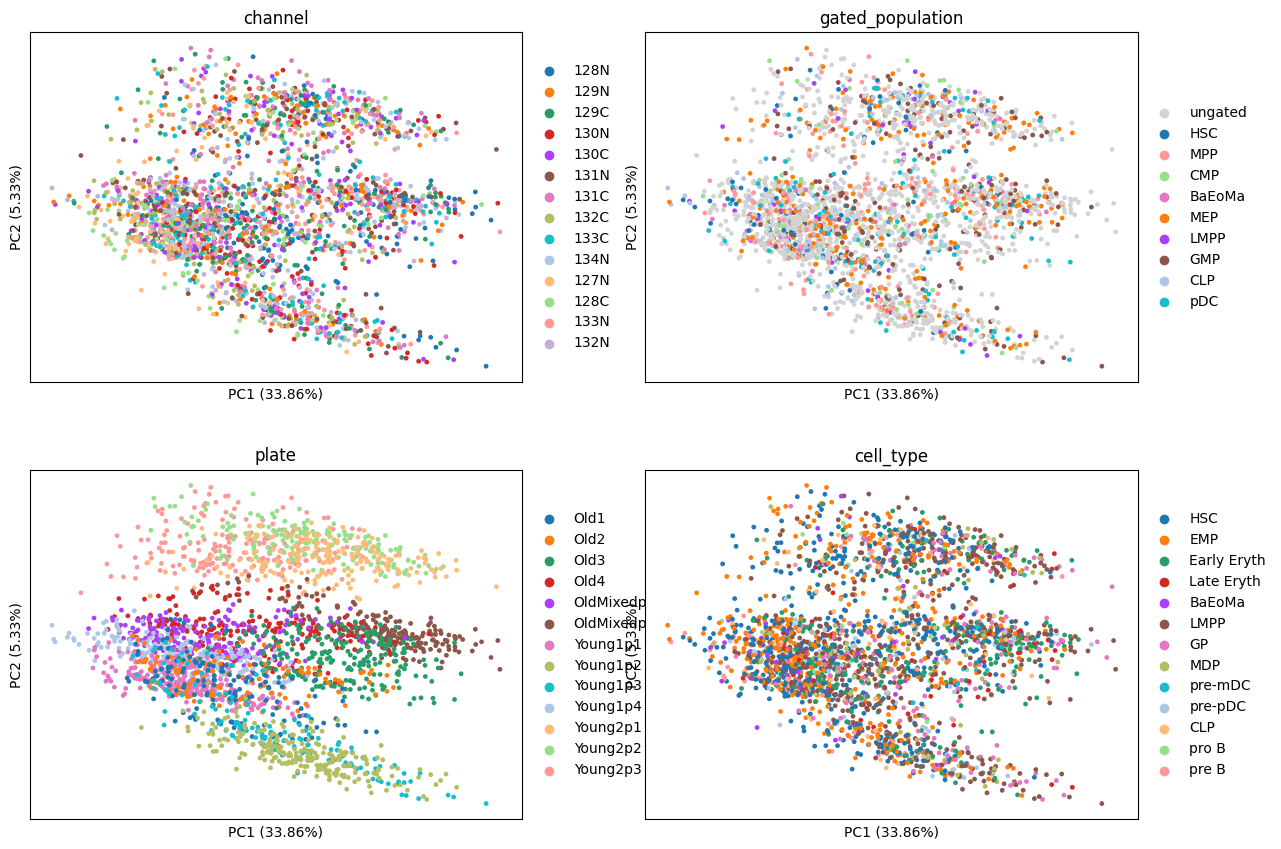

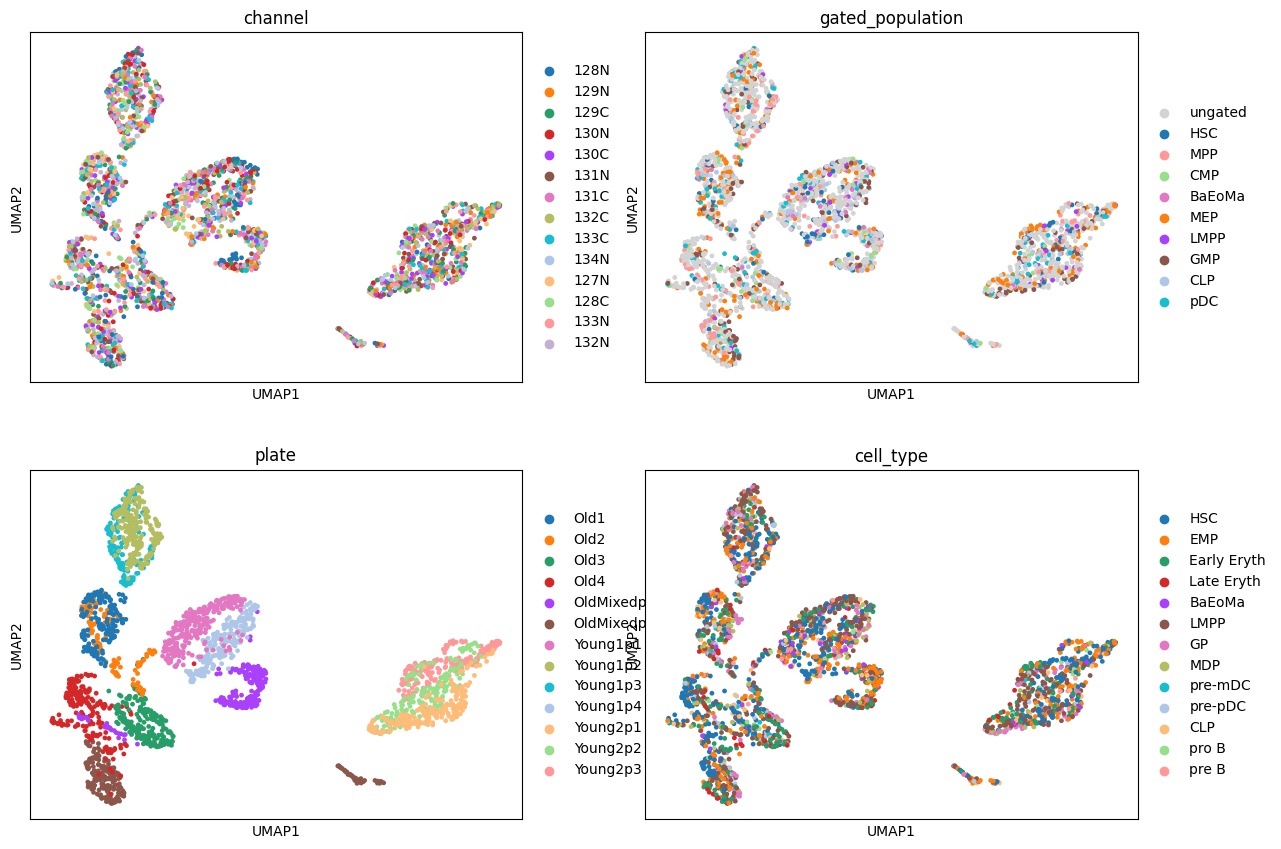

In [10]:
sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["channel", "gated_population", "plate", "cell_type"],
    ncols=2,
    components=["1,2"],
)


sc.pl.umap(
    adata,
    color=["channel", "gated_population", "plate", "cell_type"],
    ncols=2,
    vmin="p01",
    vmax="p99",
)

## PROTVI

### Training

Let's now train the model.

In [41]:
adata.X = adata.layers["log2_raw"].copy()
adata.X[np.isnan(adata.X)] = 0

In [42]:
PROTVI.setup_anndata(
    adata,
    #batch_key="file_id",
    #categorical_covariate_keys=["plate"],
    # continuous_covariate_keys=["num_proteins", "log2_sum_s/n"],
)

model = PROTVI(
    adata,
    log_variational=False,
    n_hidden=64,
    n_layers=1,
    n_latent=12,
    decoder_type="selection",
    #batch_embedding_type="embedding",
    #batch_dim=10,
)
# model.view_anndata_setup()

Let's train the model.

In [43]:
model.train(
    max_epochs=2000, plan_kwargs={"mechanism_weight": 0, "kl_weight": 1}, check_val_every_n_epoch=1
)  # , plan_kwargs={"min_kl_weight": 10, "max_kl_weight": 10}),  "lr": 1e-3

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2000/2000: 100%|██████████| 2000/2000 [11:15<00:00,  3.10it/s, v_num=1, train_loss_step=783, train_loss_epoch=780]    

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [11:15<00:00,  2.96it/s, v_num=1, train_loss_step=783, train_loss_epoch=780]


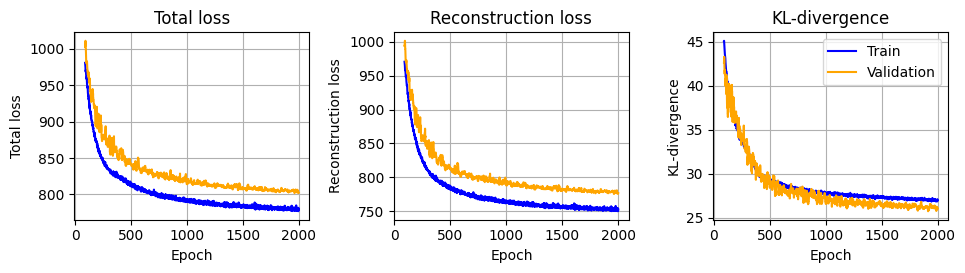

In [44]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

In [45]:
model.save("schoof2021_0")

### Hyperparameters #0

In [46]:
# kl_weight = 10
# n_latent = 12
# n_hidden = 64
# n_layers = 1
# kl_weight = 10

In [47]:
model = PROTVI.load("schoof2021_0", adata)

INFO     File schoof2021_0/model.pt already downloaded                                                             


Let's look at the latent space.

In [48]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [49]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

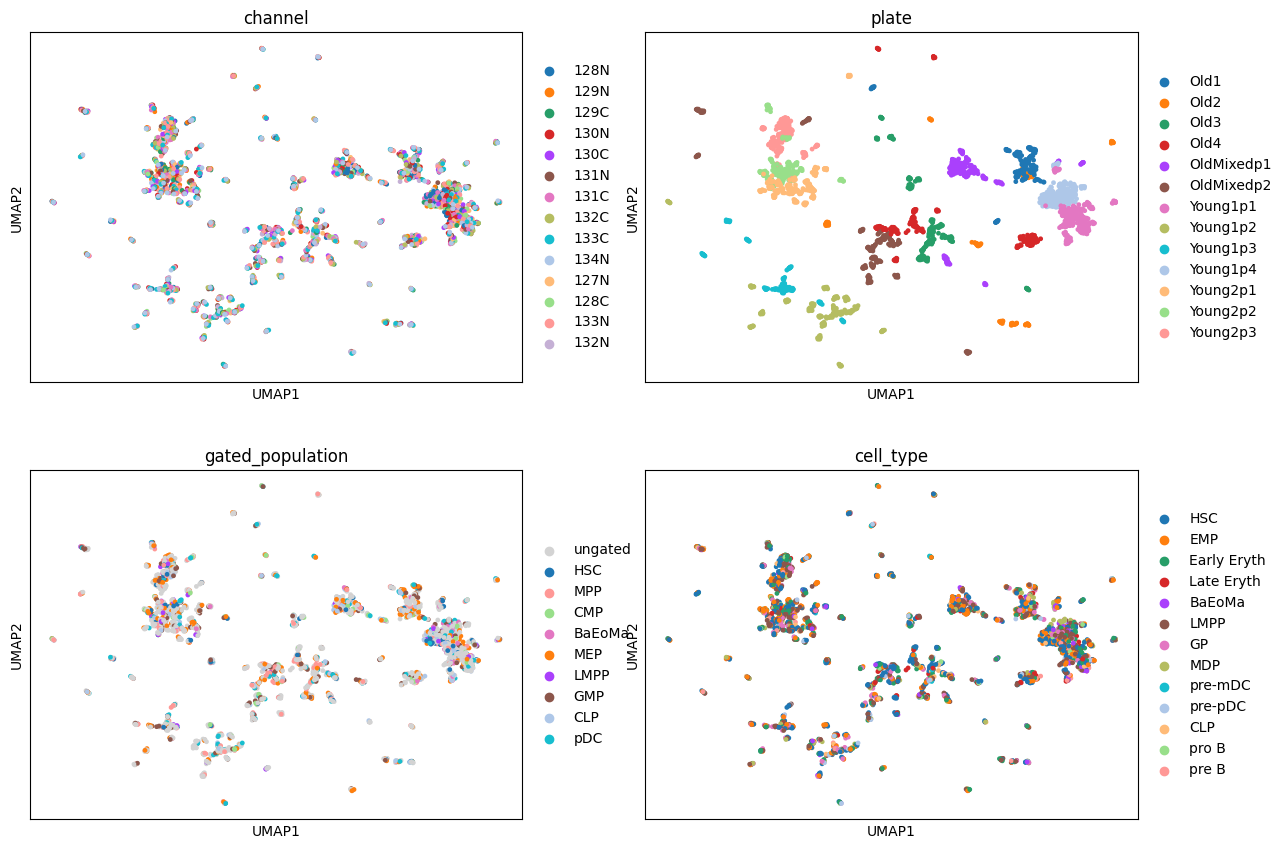

In [50]:
sc.pl.umap(
    adata,
    color=["channel", "plate", "gated_population", "cell_type"],
    ncols=2,
    vmin="p01",
    vmax="p99",
)

### Hyperparameters #1

In [ ]:
# kl_weight = 10
# batch_embedding_type = "encoder"
# batch_dim = 10
# n_latent = 12
# n_hidden = 32
# n_layers = 1
# kl_weight = 10
# batch = "file_id"
# categorical_covariate_keys=["plate"]

In [35]:
model = PROTVI.load("schoof2021_1", adata)

INFO     File schoof2021_2/model.pt already downloaded                                                             


Let's look at the latent space.

In [18]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [19]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

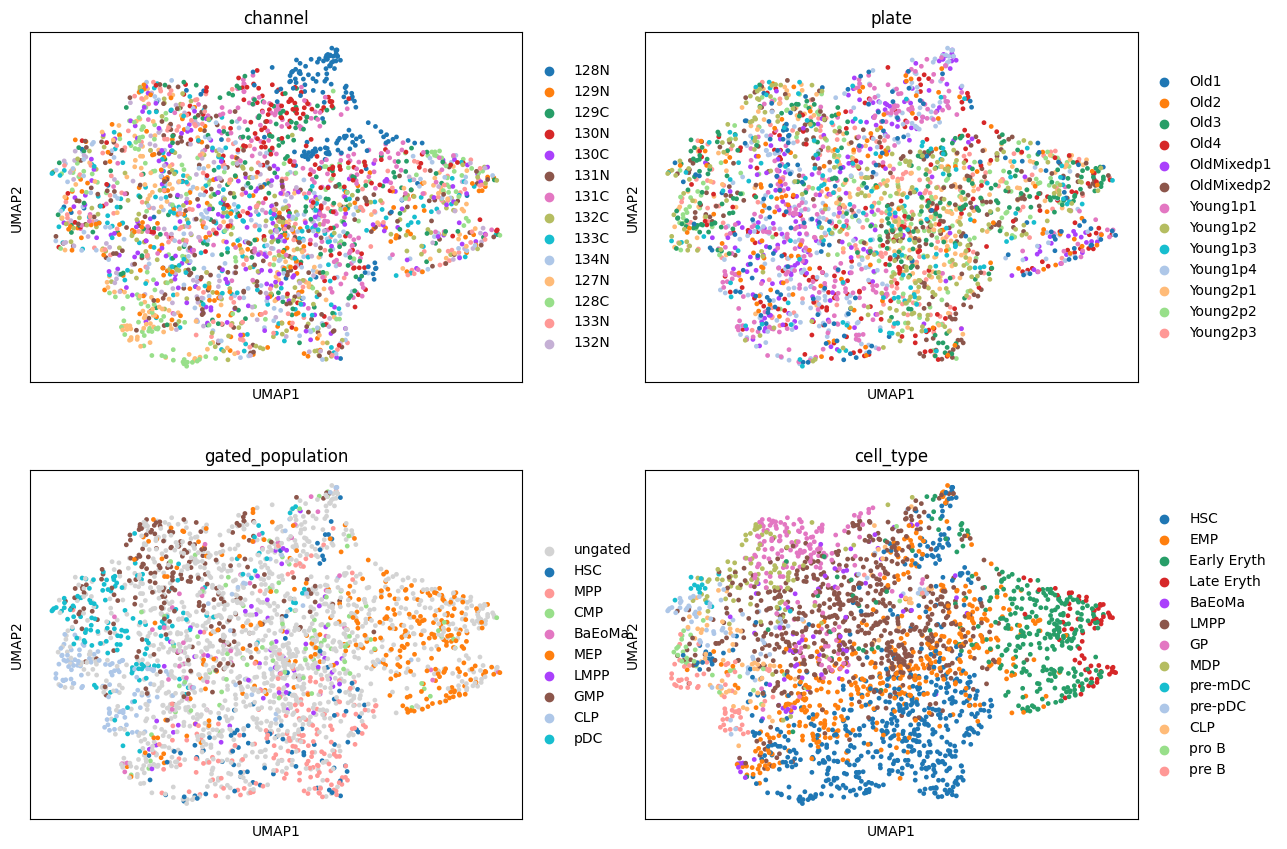

In [20]:
sc.pl.umap(
    adata,
    color=["channel", "plate", "gated_population", "cell_type"],
    ncols=2,
    vmin="p01",
    vmax="p99",
)

### Hyperparameters #2

In [36]:
# kl_weight = 10
# batch_embedding_type = None
# batch_dim = 10
# n_latent = 12
# n_hidden = 32
# n_layers = 1
# kl_weight = 10
# batch = "file_id"
# categorical_covariate_keys=["plate"]

In [37]:
model = PROTVI.load("schoof2021_2", adata)

INFO     File schoof2021_2/model.pt already downloaded                                                             


Let's look at the latent space.

In [38]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [39]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

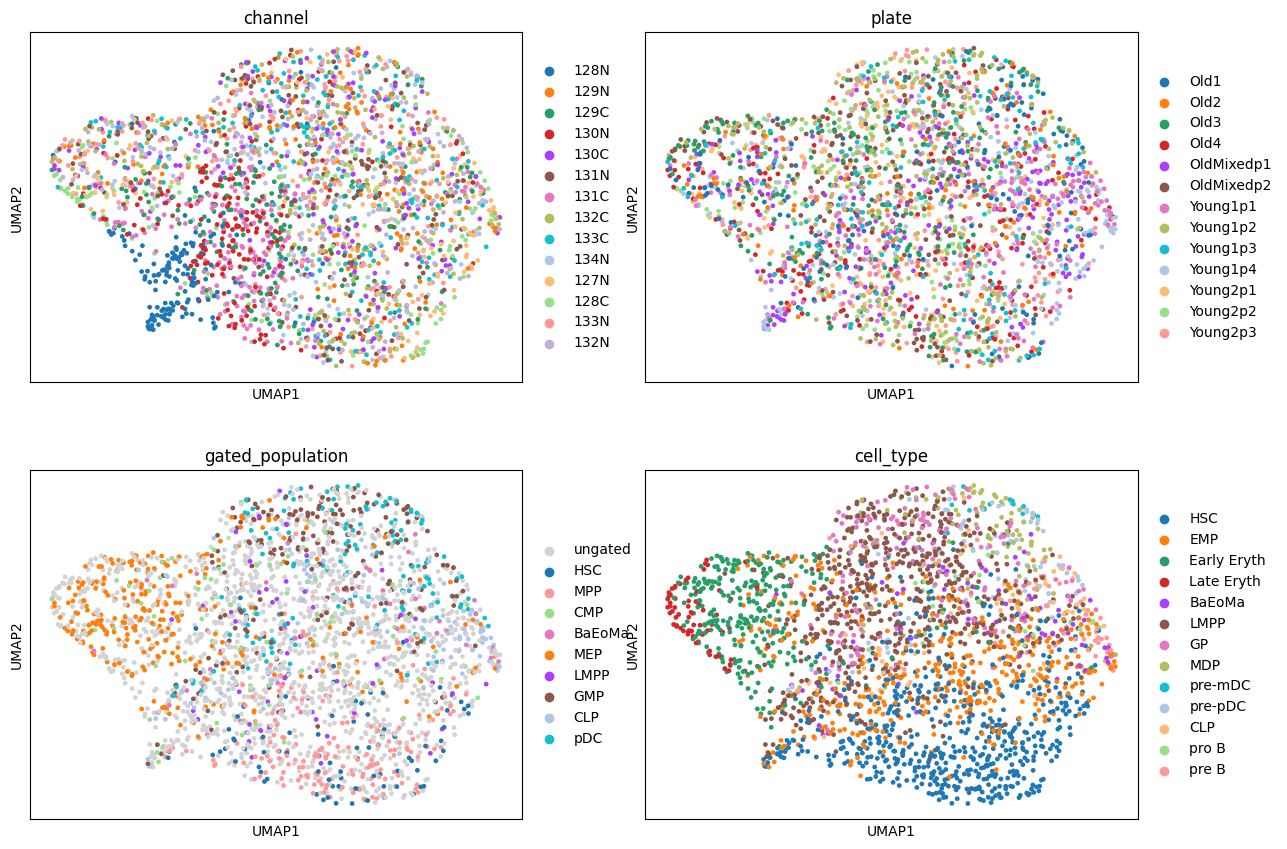

In [40]:
sc.pl.umap(
    adata,
    color=["channel", "plate", "gated_population", "cell_type"],
    ncols=2,
    vmin="p01",
    vmax="p99",
)